In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from impyute.imputation.cs import mice
from pathlib import Path
%matplotlib inline

In [2]:
DATA=Path.cwd()

In [3]:
df=pd.read_csv(DATA/'datasets'/'ames_house_prices'/'train.csv')

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Exploring information about types of data and percentage of missing values in dataset

In [5]:
df.shape

(1460, 81)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
inf=pd.DataFrame(df.dtypes, index=df.columns, columns=['dtype'])

In [8]:
inf['n_missing']=df.isna().sum()

In [9]:
inf['percentage_missing']=df.isna().sum()/df.shape[0]*100

In [10]:
inf.sort_values(['percentage_missing'], ascending=False)[:20]

,dtype,n_missing,percentage_missing
PoolQC,object,1453,99.520548
MiscFeature,object,1406,96.301370
Alley,object,1369,93.767123
Fence,object,1179,80.753425
FireplaceQu,object,690,47.260274
LotFrontage,float64,259,17.739726
GarageYrBlt,float64,81,5.547945
GarageCond,object,81,5.547945
GarageType,object,81,5.547945
GarageFinish,object,81,5.547945


Here we can see columns with a high percent of missing values. Probably it should be deleted to avoid negative effect on predictions.

PoolQC 99.520548 %, 
MiscFeature 96.301370%, 
Alley 93.767123 %, 
Fence 80.753425 %, 
FireplaceQu 47.260274 %

Dividing dataset on features and target values.

In [11]:
X=df.drop('SalePrice', axis=1)

In [12]:
y=df['SalePrice']

Dividing categorical and numerical columns and putting them on variables cat_cols and num_cols.

In [13]:
num_cols=df.columns[(df.dtypes=='int64')|(df.dtypes=='float64')]

In [14]:
cat_cols=df.columns[df.dtypes=='object']

Dividing dataset on train and test datasets.

In [15]:
test_size=0.2

In [16]:
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

Filling missing values in categorical columns with 'None'.

In [17]:
X_train_df[cat_cols]=X_train_df[cat_cols].fillna('None')

In [18]:
X_test_df[cat_cols]=X_test_df[cat_cols].fillna('None')

In [19]:
categorical_features_indices = list(cat_cols)

In [20]:
list(cat_cols)

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

Training of catboost regression model.

In [21]:
cat = CatBoostRegressor()

In [22]:
cat.fit(X_train_df, y_train, cat_features=categorical_features_indices, eval_set=(X_test_df, y_test), verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052178
0:	learn: 74577.8863904	test: 84868.4387773	best: 84868.4387773 (0)	total: 178ms	remaining: 2m 58s
200:	learn: 16058.4022350	test: 27178.1977625	best: 27178.1977625 (200)	total: 8.33s	remaining: 33.1s
400:	learn: 11674.9751079	test: 26372.3672313	best: 26368.7184451 (398)	total: 18.9s	remaining: 28.2s
600:	learn: 9235.2592081	test: 26048.0217067	best: 26044.5180653 (599)	total: 30.2s	remaining: 20s
800:	learn: 7399.4882820	test: 25934.7881690	best: 25933.0260500 (759)	total: 40.4s	remaining: 10s
999:	learn: 6216.5132834	test: 25890.6307199	best: 25886.2730109 (961)	total: 51.1s	remaining: 0us

bestTest = 25886.27301
bestIteration = 961

Shrink model to first 962 iterations.


Creating plot of change of loss for train and test datasets.

In [23]:
cat.get_evals_result()['learn'].keys()

dict_keys(['RMSE'])

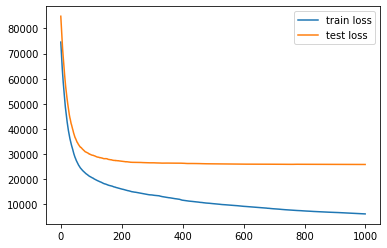

In [24]:
plt.plot(cat.get_evals_result()['learn']['RMSE'], label='train loss')
plt.plot(cat.get_evals_result()['validation']['RMSE'], label='test loss')
plt.legend()
plt.show()

Displaying number of iteration with the best loss value of the model and the best metrics of the model.

In [25]:
cat.best_iteration_

961

In [26]:
cat.best_score_

{'learn': {'RMSE': 6216.513283446953},
 'validation': {'RMSE': 25886.273010900433}}

Displaying top 10 most valuable features.

In [27]:
importance=pd.DataFrame(cat.feature_importances_, index=df.columns[1::], columns=['importance'])

In [28]:
importance=importance.sort_values(by='importance', ascending=True)[:10]

In [29]:
importance

,importance
LotConfig,0.000028
Exterior1st,0.001298
BldgType,0.003506
Alley,0.003830
BsmtFinSF2,0.006371
FullBath,0.007103
MiscVal,0.007468
GrLivArea,0.016117
HouseStyle,0.035187
3SsnPorch,0.038875


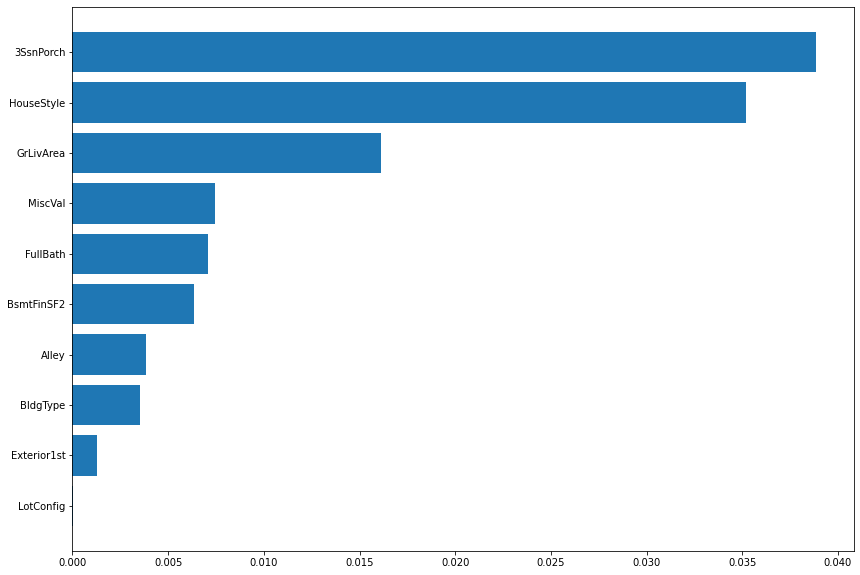

In [30]:
plt.figure(figsize=(14, 10))
plt.barh(importance.index, importance['importance'])
plt.show()

Delete columns that have a high percentage of missing values and train of model with new dataset.

In [31]:
df_drop=df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)

In [32]:
df_drop

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


Dividing dataset on train and test datasets.

In [33]:
X=df_drop.drop('SalePrice', axis=1)
y=df_drop['SalePrice']

In [34]:
test_size=0.2

In [35]:
X_drop_train_df, X_drop_test_df, y_drop_train, y_drop_test = train_test_split(X, y, test_size=test_size, 
                                                                              shuffle=True, random_state=42)

In [36]:
X_drop_train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,255,20,RL,70.0,8400,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,6,2010,WD,Normal
1066,1067,60,RL,59.0,7837,Pave,IR1,Lvl,AllPub,Inside,...,40,0,0,0,0,0,5,2009,WD,Normal
638,639,30,RL,67.0,8777,Pave,Reg,Lvl,AllPub,Inside,...,0,164,0,0,0,0,5,2008,WD,Normal
799,800,50,RL,60.0,7200,Pave,Reg,Lvl,AllPub,Corner,...,0,264,0,0,0,0,6,2007,WD,Normal
380,381,50,RL,50.0,5000,Pave,Reg,Lvl,AllPub,Inside,...,0,242,0,0,0,0,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,20,RL,78.0,9317,Pave,IR1,Lvl,AllPub,Inside,...,22,0,0,0,0,0,3,2007,WD,Normal
1130,1131,50,RL,65.0,7804,Pave,Reg,Lvl,AllPub,Inside,...,44,0,0,0,0,0,12,2009,WD,Normal
1294,1295,20,RL,60.0,8172,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2006,WD,Normal
860,861,50,RL,55.0,7642,Pave,Reg,Lvl,AllPub,Corner,...,240,0,0,0,0,0,6,2007,WD,Normal


Filling missing values in numerical columns of X_train_df and X_test_df with MICE.

In [37]:
num_cols=num_cols.drop(['SalePrice'])

In [38]:
imputed_training=mice(X_drop_train_df[num_cols].values)

In [39]:
X_drop_train_df[num_cols]= pd.DataFrame(imputed_training, columns=X_drop_train_df[num_cols].columns, index=X_drop_train_df.index)

In [40]:
imputed_testing=mice(X_drop_test_df[num_cols].values)

In [41]:
X_drop_test_df[num_cols] = pd.DataFrame(imputed_testing, columns=X_drop_train_df[num_cols].columns, index=X_drop_test_df.index)

Filling missing values in categorical columns with most frequent value using SimpleImputer.

In [42]:
cat_cols=X_drop_train_df.columns[X_drop_train_df.dtypes=='object']

In [43]:
imp_mean = SimpleImputer(strategy='most_frequent')
imp_mean.fit(X_drop_train_df[cat_cols])
X_drop_train_df[cat_cols] = pd.DataFrame(imp_mean.transform(X_drop_train_df[cat_cols]),
                                columns=X_drop_train_df[cat_cols].columns, index=X_drop_train_df.index)
X_drop_test_df[cat_cols]= pd.DataFrame(imp_mean.transform(X_drop_test_df[cat_cols]), 
                                columns=X_drop_test_df[cat_cols].columns, index=X_drop_test_df.index)

Training catboost regression model with new train and test datasets.
Exploring new metrics of the model.

In [44]:
categorical_features_indices=list(cat_cols)

In [45]:
categorical_features_indices

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [46]:
cat.fit(X_drop_train_df, y_drop_train, cat_features=categorical_features_indices, eval_set=(X_drop_test_df, y_drop_test),
        verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052178
0:	learn: 74634.2039958	test: 84946.9750384	best: 84946.9750384 (0)	total: 24.5ms	remaining: 24.5s
200:	learn: 16211.0702914	test: 27942.6000453	best: 27942.6000453 (200)	total: 6.99s	remaining: 27.8s
400:	learn: 12102.2611196	test: 27176.6237409	best: 27176.6237409 (400)	total: 13.9s	remaining: 20.8s
600:	learn: 9437.2705429	test: 26723.8696333	best: 26721.6809447 (599)	total: 22.2s	remaining: 14.8s
800:	learn: 7772.6860054	test: 26617.3622990	best: 26600.8732533 (792)	total: 32.4s	remaining: 8.06s
999:	learn: 6505.1657786	test: 26588.7831111	best: 26581.7706305 (986)	total: 42.4s	remaining: 0us

bestTest = 26581.77063
bestIteration = 986

Shrink model to first 987 iterations.


In [47]:
cat.best_score_

{'learn': {'RMSE': 6505.1657786093065},
 'validation': {'RMSE': 26581.770630499213}}

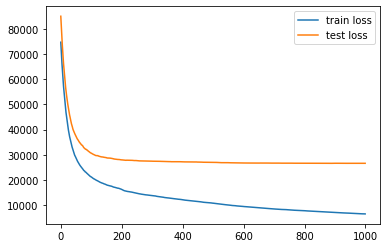

In [48]:
plt.plot(cat.get_evals_result()['learn']['RMSE'], label='train loss')
plt.plot(cat.get_evals_result()['validation']['RMSE'], label='test loss')
plt.legend()
plt.show()

In [49]:
importance=pd.DataFrame(cat.feature_importances_, index=df_drop.columns[1::], columns=['importance'])

In [50]:
importance=importance.sort_values(by='importance', ascending=True)[:10]

In [51]:
importance

,importance
LotShape,0.000000
LotConfig,0.001968
GarageCond,0.005391
Exterior1st,0.005650
GrLivArea,0.005769
HeatingQC,0.008005
FullBath,0.010007
PavedDrive,0.014631
BsmtFinSF2,0.034592
1stFlrSF,0.041746


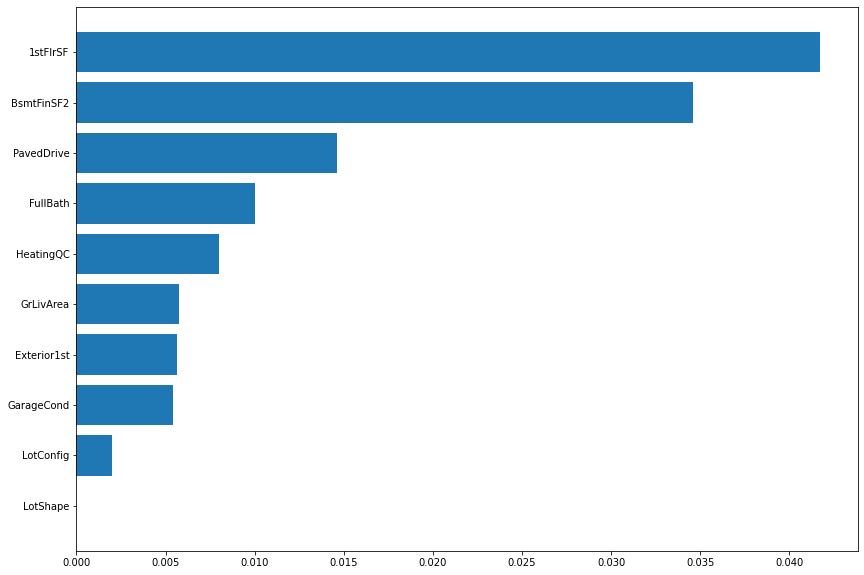

In [52]:
plt.figure(figsize=(14, 10))
plt.barh(importance.index, importance['importance'])
plt.show()

The metrics of the last model are not significant different from the previous model (its little bit worse), the number of iterations and time becomes bigger comparing to the first model. Valuable features totally different for two models. First and second models have 4 common most valuable features:'BsmtFinSF2', 'LotConfig', 'GrLivArea', 'BldgType'. Important for the first model features 'Miscval' and 'Alley' have a lot of missing values, so it was deleted from the dataset and second model didn't use these data for training. So the conclusion is that filling of missing values in this particular way didn't help to improve metrics for catboost regression model. 